In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

file_path = 'your_dataset.csv' 
data = pd.read_csv(file_path)

data


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.205492,5.823226,98.837539,-1.075852,0.999205,0.911543,3.623558,-1.720267,-0.346191,-54.708330,-1
1,1.391530,3.611581,98.857197,-5.020318,0.677165,0.999492,3.413112,4.253865,2.041603,-54.317291,1
2,1.692571,-0.887019,100.901276,-0.595548,0.177550,-0.915495,4.320264,0.907834,3.126815,-56.397484,-1
3,4.289320,1.416843,100.784735,-2.897154,-0.066972,-0.786173,2.093003,1.336237,2.183829,-56.197728,1
4,0.542420,-1.010095,100.015580,-3.070705,0.088324,-0.242669,0.767942,-0.284683,-2.104145,-55.794045,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.481134,-0.572225,99.274788,-0.868047,-0.663229,0.572447,5.163238,1.765743,0.720265,-54.952233,-1
9996,0.047373,0.990198,100.444834,-0.707179,0.912113,-0.510397,1.128577,0.116130,-2.559018,-56.008656,-1
9997,1.741933,0.036304,100.524071,-0.113742,-0.761337,-0.728295,-1.334732,-1.312760,-0.442573,-56.170876,-1
9998,2.574986,0.041442,98.983735,-1.937883,0.983004,0.798133,5.847342,0.904038,-1.695064,-54.820699,1


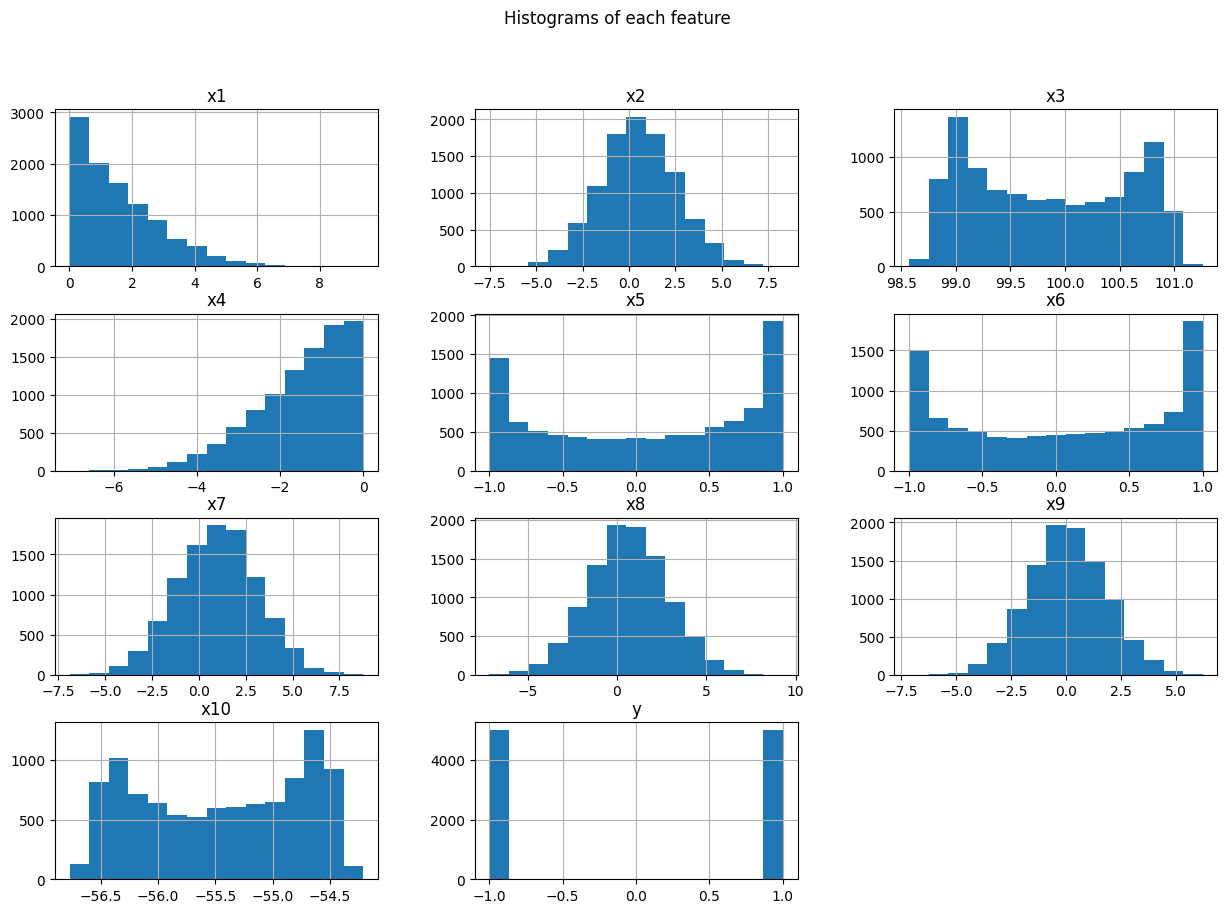

In [3]:
data.hist(bins=15, figsize=(15, 10))
plt.suptitle('Histograms of each feature')
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
X = data.drop('y', axis=1)
y = data['y']

X.fillna(X.mean(), inplace=True)
X = (X - X.mean()) / X.std()

In [5]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
def zero_one_loss(y_true,y_pred):
    if(y_pred == y_true):
        return 0
    else:
        return 1

In [7]:
def error(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)
    sum = 0
    for i in range(n-1):
        sum += zero_one_loss(y_true[i], y_pred[i])
    return sum/n

***SVM Pegasos***

In [12]:
class PegasosSVM:
    def __init__(self, lambda_, epoch):
        self.lambda_ = lambda_
        self.epoch = epoch
        self.w = None

    def fit(self, X, y):
        
        X = np.asarray(X)
        y = np.asarray(y)

        m, d = X.shape  
        self.w = np.zeros(d)
        wt_sum = np.zeros(d)  

        for t in range(1, self.epoch + 1):
            i = np.random.randint(m)  
            x_i, y_i = X[i], y[i]

            eta_t = 1 / (self.lambda_ * t)

            if y_i * np.dot(self.w, x_i) < 1:
                self.w = (1 - eta_t * self.lambda_) * self.w + eta_t * y_i * x_i
            else:
                self.w = (1 - eta_t * self.lambda_) * self.w

            wt_sum += self.w

        self.w = wt_sum / self.epoch

    def predict(self, X):
        return np.sign(np.dot(X, self.w))

In [77]:
import itertools
from sklearn.model_selection import KFold

def cross_validation(param_grid, X, Y, K=5):
    
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    errors = []
    best_params_overall = None
    best_error_overall = float('inf')

    X = np.array(X)  
    Y = np.array(Y)  

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]

        best_params_fold = None
        best_error_fold = float('inf')

        for combination in itertools.product(*param_grid.values()):
            params = dict(zip(param_grid.keys(), combination))
            model = PegasosSVM(lambda_=params['lambda_'], epoch=params['epoch'])
            model.fit(X_train, Y_train)
            predictions = model.predict(X_val)
            error_ = error(Y_val,predictions)

            if error_ < best_error_fold:
                best_error_fold = error_
                best_params_fold = params

        errors.append(best_error_fold)

        if best_error_fold < best_error_overall:
            best_error_overall = best_error_fold
            best_params_overall = best_params_fold

    avg_error = np.mean(errors)
    return avg_error, best_params_overall

In [14]:
param_grid = {
    'lambda_': [0.0001, 0.001, 0.01, 0.1, 1],
    'epoch': [500, 1000, 2000, 5000, 10000]
}

avg_error, best_params = cross_validation(param_grid, X_train, y_train, K=5)
print("Average Training Error for SVM pegasos:", avg_error)
print("Best Parameters:", best_params)

Average Training Error for SVM pegasos: 0.27025
Best Parameters: {'lambda_': 0.01, 'epoch': 10000}


In [15]:
svm = PegasosSVM(lambda_=0.1, epoch=1000)
svm.fit(X_train, y_train)

In [16]:
predictions_test = svm.predict(X_test)
print("The test error for SVM pegasos is: ", error(y_test,predictions_test))

The test error for SVM pegasos is:  0.281


***Perceptron***

In [25]:
class Perceptron:
    def __init__(self, eta=1.0, max_epochs=1000):
        self.w = None
        self.eta = eta
        self.max_epochs = max_epochs

    def fit(self, X, y):
        X = np.array(X)  
        y = np.array(y)
        m, n = X.shape
        self.w = np.zeros(n + 1)  
        
        for epoch in range(self.max_epochs):
            no_update = True
            for t in range(m):
                if y[t] * (np.dot(self.w[:-1], X[t]) + self.w[-1]) <= 0:
                    self.w[:-1] += self.eta * y[t] * X[t]
                    self.w[-1] += self.eta * y[t]
                    no_update = False
            if no_update:
                break

    def predict(self, X):
        return np.sign(np.dot(X, self.w[:-1]) + self.w[-1])

In [32]:
def cross_validate_perceptron(X, y, k=5, eta_values=[1.0], max_epochs_values=[1000]):
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    best_score = 0
    best_params = {'eta': None, 'max_epochs': None}
    X = np.array(X)  
    y = np.array(y)
    for eta in eta_values:
        for max_epochs in max_epochs_values:
            scores = []
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                model = Perceptron(eta=eta, max_epochs=max_epochs)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                score = error(y_test, y_pred)
                scores.append(score)

            average_score = np.mean(scores)
            if average_score > best_score:
                best_score = average_score
                best_params['eta'] = eta
                best_params['max_epochs'] = max_epochs

    return average_score, best_params


In [36]:
average_error, best_params = cross_validate_perceptron(X_train, y_train, k=5, eta_values=[0.01, 0.1, 1.0], max_epochs_values=[10, 100])
print("Average training error:", average_error)
print("Best Parameters:", best_params)


Average training error: 0.391
Best Parameters: {'eta': 0.01, 'max_epochs': 100}


In [37]:
perceptron = Perceptron(eta=0.01,max_epochs=100)
perceptron.fit(X_train, y_train)

In [38]:
y_preds_test = perceptron.predict(X_test)
print("Test Error for the Perceptron: ",error(y_test, y_preds_test))

Test Error for the Perceptron:  0.338


***Regularized Logistic Classification***

In [19]:
class Logistic_SVM:
    def __init__(self, lambda_, epoch):
        self.lambda_ = lambda_
        self.epoch = epoch
        self.w = None

    def fit(self, X, y):
        
        X = np.asarray(X)
        y = np.asarray(y)

        m, d = X.shape 
        self.w = np.zeros(d)
        wt_sum = np.zeros(d) 

        for t in range(1, self.epoch + 1):
            
            i = np.random.randint(m)  
            x_i, y_i = X[i], y[i]

            eta_t = 1 / (self.lambda_ * t)

            sigmoid = 1.0 / (1 + np.exp(y_i * np.dot(self.w, x_i)))
            gradient = -y_i * x_i * sigmoid

            self.w = (1 - eta_t * self.lambda_) * self.w + eta_t * gradient

            wt_sum += self.w

        self.w = wt_sum / self.epoch

    def predict(self, X):
        return np.sign(np.dot(X, self.w))

In [14]:
def cross_validation_log(param_grid, X, Y, K=5):
    
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    errors = []
    best_params_overall = None
    best_error_overall = float('inf')

    X = np.array(X)  
    Y = np.array(Y)  

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]

        best_params_fold = None
        best_error_fold = float('inf')

        for combination in itertools.product(*param_grid.values()):
            params = dict(zip(param_grid.keys(), combination))
            model = Logistic_SVM(lambda_=params['lambda_'], epoch=params['epoch'])
            model.fit(X_train, Y_train)
            predictions = model.predict(X_val)
            error_ = error(Y_val,predictions)

            if error_ < best_error_fold:
                best_error_fold = error_
                best_params_fold = params

        errors.append(best_error_fold)

        if best_error_fold < best_error_overall:
            best_error_overall = best_error_fold
            best_params_overall = best_params_fold

    avg_error = np.mean(errors)
    return avg_error, best_params_overall

In [24]:
param_grid = {
    'lambda_': [0.01, 0.1, 1],
    'epoch': [500, 1000, 2000, 5000, 10000]
}

avg_error, best_params = cross_validation_log(param_grid, X_train, y_train, K=5)
print("Average Training Error for regularized logistic regression:", avg_error)
print("Best Parameters:", best_params)

Average Training Error for regularized logistic regression: 0.5315
Best Parameters: {'lambda_': 0.01, 'epoch': 500}


In [25]:
log_pegasos = Logistic_SVM(lambda_=0.01, epoch=500)
log_pegasos.fit(X_train,y_train)

In [26]:
log_pred_test = log_pegasos.predict(X_test)
print("For regularized logistic regression the test error is: ", error(y_test,log_pred_test))

For regularized logistic regression the test error is:  0.5575


***Polynomial Feature Expansion***

In [25]:
from sklearn.preprocessing import PolynomialFeatures

def expand_features(X, degree=2):
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(X)


In [26]:
X_expanded = expand_features(X)
svm = PegasosSVM(lambda_=0.1, epoch=1000)
svm.fit(X_expanded, y)


In [27]:
expand_preds = svm.predict(X_expanded)
print("With poly feature expansion of degree 2 error of pegasos: ", error(y,expand_preds))

With poly feature expansion of degree 2 error of pegasos:  0.156


In [28]:
perceptron = Perceptron(eta=0.01,max_epochs=100)
perceptron.fit(X_expanded, y)

In [29]:
p_expand_preds = perceptron.predict(X_expanded)
print("With poly feature expansion of degree 2 error of perceptron: ", error(y,p_expand_preds))

With poly feature expansion of degree 2 error of perceptron:  0.0819


In [30]:
log_pegasos = Logistic_SVM(lambda_=0.1, T=100)
log_pegasos.fit(X_expanded,y)

In [31]:
log_pred_expanded = log_pegasos.predict(X_expanded)
print("For regularized logistic regression the training error is: ", error(y,log_pred_expanded))

For regularized logistic regression the training error is:  0.5008


***Kernel Perceptron***

In [8]:
from numpy import linalg
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, gamma =1.0):
    return np.exp(-linalg.norm(x-y)**2.0 / (2 * (gamma)))


In [118]:
class KernelPerceptron:
    def __init__(self, kernel_func):
        self.kernel_func = kernel_func
        self.support_vectors = []
        self.support_labels = []
        self.support_alpha = []

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]

        for t in range(n_samples):
            x_t = X[t]
            y_t = y[t]

            prediction = 0
            for alpha, x_s, y_s in zip(self.support_alpha, self.support_vectors, self.support_labels):
                prediction += alpha * y_s * self.kernel_func(x_s, x_t)
            
            if np.sign(prediction) != y_t:
                self.support_vectors.append(x_t)
                self.support_labels.append(y_t)
                self.support_alpha.append(1)  

    def predict(self, X):
        X = np.array(X)
        y_pred = np.zeros(X.shape[0])
        for i, x_t in enumerate(X):
            prediction = 0
            for alpha, x_s, y_s in zip(self.support_alpha, self.support_vectors, self.support_labels):
                prediction += alpha * y_s * self.kernel_func(x_s, x_t)
            y_pred[i] = np.sign(prediction)
        return y_pred

In [119]:
kernelP_G = KernelPerceptron(kernel_func=lambda x,y:gaussian_kernel(x,y,gamma=0.1))
kernelP_G.fit(X_train,y_train)

In [130]:
gaussian_results_train = kernelP_G.predict(X_train)

In [132]:
gaussian_results_test = kernelP_G.predict(X_test)

In [133]:
error_g_perc_train = error(y_train,gaussian_results_train)
print("For gaussian perceptron the training error is: ", error_g_perc_train)

For gaussian perceptron the training error is:  0.0685


In [134]:
error_g_perc_test = error(y_test,gaussian_results_test)
print("For gaussian perceptron the test error is: ", error_g_perc_test)

For gaussian perceptron the test error is:  0.192


In [135]:
kernelP_P = KernelPerceptron(kernel_func=lambda x,y:polynomial_kernel(x,y,p=2))
kernelP_P.fit(X_train,y_train)

In [136]:
polynomial_results_train = kernelP_P.predict(X_train)

In [137]:
polynomial_results_test = kernelP_P.predict(X_test)

In [138]:
error_p_perc_train = error(y_train,polynomial_results_train)
print("For polynomial perceptron the training error is: ", error_p_perc_train)

For polynomial perceptron the training error is:  0.10525


In [139]:
error_p_perc_test = error(y_test,polynomial_results_test)
print("For polynomial perceptron the test error is: ", error_p_perc_test)

For polynomial perceptron the test error is:  0.109


***Kernel Pegasos***

In [59]:
class KernelPegasos:
    def __init__(self, kernel, lambda_, epochs):
        self.lambda_ = lambda_
        self.epochs = epochs
        self.kernel = kernel
        self.alpha = None
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        m = len(self.X_train)
        self.alpha = np.zeros(m)

        for t in range(1, self.epochs + 1):
            i = np.random.randint(m)
            eta_t = 1 / (self.lambda_ * t)
            margin = sum(self.alpha[j] * self.y_train[j] * self.kernel(self.X_train[j], self.X_train[i]) for j in range(m))

            if self.y_train[i] * margin < 1:
                self.alpha[i] += eta_t  

    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            prediction = sum(self.alpha[j] * self.y_train[j] * self.kernel(self.X_train[j], x) for j in range(len(self.X_train)))
            predictions.append(np.sign(prediction))
        return np.array(predictions)

In [86]:
pegasos = KernelPegasos(kernel=lambda x,y:gaussian_kernel(x,y,gamma=0.01),lambda_=0.001, epochs=1000)
pegasos.fit(X_train, y_train)

In [87]:
gaussian_pegasos_train = pegasos.predict(X_train)

In [88]:
print("For gaussian pegasos the training error is: ", error(gaussian_pegasos_train,y_train))

For gaussian pegasos the training error is:  0.18725


In [89]:
gaussian_pegasos_test = pegasos.predict(X_test)

In [90]:
print("For gaussian pegasos the test error is: ", error(gaussian_pegasos_test,y_test))

For gaussian pegasos the test error is:  0.179


In [99]:
p_pegasos = KernelPegasos(kernel=lambda x,y:polynomial_kernel(x,y,p=4),lambda_=0.001, epochs=10000)
p_pegasos.fit(X_train, y_train)

In [100]:
polynomial_pegasos_train = p_pegasos.predict(X_train)

In [101]:
print("For polynomial pegasos the training error is: ", error(polynomial_pegasos_train,y_train))

For polynomial pegasos the training error is:  0.274125


In [102]:
polynomial_pegasos_test = p_pegasos.predict(X_test)

In [103]:
print("For polynomial pegasos the test error is: ", error(polynomial_pegasos_test,y_test))

For polynomial pegasos the test error is:  0.2535
